# A Graph Neural Network from Scratch for semantic image segmentation
# Goals : 
1. An illustration of GCN for node classification
2. A toy applicaion to skin detection
3. A lecture on Structured Machine Learning

# Author: Romain Raveaux (romain.raveaux@univ-tours.fr)
## This notebook is a follow-up of "A Simple Graph Neural Network from Scratch for graph classification" see the link : 
http://romain.raveaux.free.fr/document/TP%20DI%20Graph%20Letter%20Classification%20Student-Correction.html

## Install requirements

*   [Network](https://networkx.github.io/)
*   [Pytorch](https://pytorch.org/)


# The lecture
The content of the is notebook is based on the following lectures : 
Supervised Machine Learning for structured input/output: Polytech, Tours

*   1\. Introduction to supervised Machine Learning: A probabilistic introduction [PDF](http://romain.raveaux.free.fr/document/courssupervisedmachinelearningRaveaux.pdf)

*   2\. Connecting local models : The case of chains [PDF slides](http://romain.raveaux.free.fr/document/Connecting%20local%20models%20the%20case%20of%20chains%20.pdf)

*   3\. Connecting local models : Beyond chains and trees.[PDF slides](http://romain.raveaux.free.fr/document/Structured%20Output%20Learning.pdf)

*   4\. Machine Learning and Graphs : Introduction and problems [PDF slides](http://romain.raveaux.free.fr/document/cours%20IA%20DI5%20graphs%20introV2.pdf)

*   5\. **Graph Neural Networks.** [PDF slides](http://romain.raveaux.free.fr/document/graph%20neural%20networks%20romain%20raveaux.pdf)

*   6\. Graph Kernels. [PDF slides](http://romain.raveaux.free.fr/document/graph%20kernel%20romain%20raveaux.pdf)


In [2]:
#load of import
import numpy as np
import matplotlib.image as Image
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from skimage.transform import resize
from skimage.transform import rescale


In [2]:
# if needed 
#!pip install networkx
#!pip install torch
#!pip install scipy
#!pip install matplotlib

# Reading some data. Getting in touch with our data

(180, 150, 3)
[ 8  8 10]


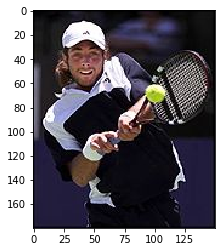

In [3]:
im=Image.imread('./data/image/image (1).jpg')
plt.figure(1)
plt.imshow(im)
print(im.shape)
print(im[5,5])


# Rescaling the data such the largest dimension is equal to 100

(100, 83, 3)
[0.06017482 0.06017482 0.06801795]


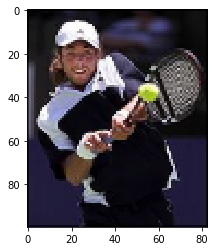

In [4]:
largestdim = 100
rescalefactor=largestdim/float(np.max(im.shape))
im = rescale(im,rescalefactor,multichannel=True)
plt.figure(2)
plt.imshow(im)
print(im.shape)
print(im[5,5])
                

# Reading the mask of skin pixels

(180, 150, 3)
[0. 0. 0.]
(100, 83, 3)
[0. 0. 0.]


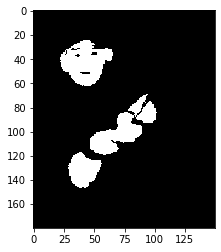

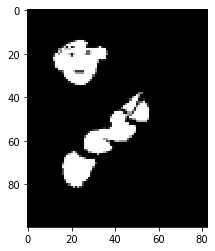

In [5]:
im=Image.imread('./data/mask/mask (1).png')
plt.figure(1)
plt.imshow(im)
print(im.shape)
print(im[5,5])

largestdim = 100
rescalefactor=largestdim/float(np.max(im.shape))
im = rescale(im,rescalefactor,multichannel=True)
plt.figure(2)
plt.imshow(im)
print(im.shape)
print(im[5,5])


# Creating a grid graph with RGB features

In [6]:
G=nx.grid_2d_graph(im.shape[0], im.shape[1], periodic=False, create_using=None)
node_label = {}
for x in range(0,im.shape[0]):
    for y in range(0,im.shape[1]):
        node_label[(x,y)]=im[x,y]
        
nx.set_node_attributes(G,node_label,'feature')

print(len(G.nodes))
print(len(G.edges))
print(G.number_of_nodes())
print(G.number_of_edges())


listnodes = list(G.nodes(data='feature'))
n=listnodes[0]
print(n)
print(n[1])


8300
16417
8300
16417
((0, 0), array([0., 0., 0.], dtype=float32))
[0. 0. 0.]


# Reading an image and returning a graph and the image dimensions

In [7]:
def readimage(file,largestdim):
    im=Image.imread(file)
    im = rescale(im,1,multichannel=True)
    r=im.shape[0]
    c=im.shape[1]
    if np.max([r,c])>largestdim:
        rescalefactor=largestdim/float(np.max([r,c]))
        im = rescale(im,rescalefactor,multichannel=True)#resize(im, (im.shape[0], im.shape[1]))
        r=im.shape[0]
        c=im.shape[1]
    
    G=nx.grid_2d_graph(im.shape[0], im.shape[1], periodic=False, create_using=None)
    node_label = {}
    for x in range(0,im.shape[0]):
        for y in range(0,im.shape[1]):
            node_label[(x,y)]=im[x,y,0:3]
        
    nx.set_node_attributes(G,node_label,'feature')
    return G,(r, c)

In [8]:
G,(r,c)=readimage('./data/image/image (1).jpg',28)
nodelist, nodesfeatures = map(list, zip(*G.nodes(data='feature')))
print(len(nodelist))
print(len(nodesfeatures))
print(nodelist[60])
print(nodesfeatures[60])
print((r,c))

644
644
(2, 14)
[0.20229884 0.17564802 0.25133611]
(28, 23)


# Reading the mask of skin pixels and returning a graph

In [9]:
def readimagemask(file,r,c):
    im=Image.imread(file)
    im = resize(im, (r, c))
    G=nx.grid_2d_graph(im.shape[0], im.shape[1], periodic=False, create_using=None)
    node_label = {}
    for x in range(0,im.shape[0]):
        for y in range(0,im.shape[1]):
            sumvec=im[x,y].sum()
            if sumvec<0.5:
                node_label[(x,y)]=0
            else:
                node_label[(x,y)]=1
        
    nx.set_node_attributes(G,node_label,'feature')
    return G


In [10]:
G=readimagemask('./data/mask/mask (1).png',28,28)
nodelist, nodesfeatures = map(list, zip(*G.nodes(data='feature')))
print(len(nodelist))
print(len(nodesfeatures))
print(nodelist[660])
print(nodelist[660])
print(nodesfeatures[660])

784
784
(23, 16)
(23, 16)
0


#### Define Dataset Class
Pytorch provides an abstract class representig a dataset, ```torch.utils.data.Dataset```. We need to override two methods:

*   ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
*   ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get i-th sample


In [11]:
import torch.utils.data as data
from torch.utils.data import DataLoader

class SkinNotSkin(data.Dataset):
  def __init__(self, root_path,trainortest,largestdim):
    self.root = root_path
    image_path=root_path+"/image/"
    mask_path=root_path+"/mask/"
    self.imagefiles=[]
    self.maskfiles=[]
    self.trainortest=trainortest
    self.largestdim=largestdim
    
    ## the first image is used for training
    start=1
    end=2#40
    if trainortest==False:
        ## the 8 last images are used for testing
        start=40
        end=49
        
    for i in range(start,end):
        s1=image_path+"image ("+str(i)+").jpg"
        self.imagefiles.append(s1)
        s2=mask_path+"mask ("+str(i)+").png"
        self.maskfiles.append(s2)
    
    
  def __getitem__(self, index):
    # Read the graph and label
    if self.trainortest==True:
        gimage,rc = readimage(self.imagefiles[index],self.largestdim)
        gmask = readimagemask(self.maskfiles[index],rc[0],rc[1])
    else :
        gimage,rc = readimage(self.imagefiles[index],self.largestdim)
        gmask = readimagemask(self.maskfiles[index],rc[0],rc[1])
        
    
    nodelist, nodesfeatures = map(list, zip(*gimage.nodes(data='feature')))
    nodesfeatures = np.array(nodesfeatures)
    edges = np.array(nx.adjacency_matrix(gimage, nodelist=nodelist).todense())
    
    
    targetlist, targetfeatures = map(list, zip(*gmask.nodes(data='feature')))
    targetfeatures = np.array(targetfeatures)
    return nodesfeatures, edges, targetfeatures,rc
  
  
  def __len__(self):
    # Subset length
    return len(self.imagefiles)



In [12]:

# Define the corresponding subsets for train, validation and test.
largestdim=100
trainset = SkinNotSkin('./data', True,largestdim)
testset = SkinNotSkin('./data', False,largestdim)


print(trainset.__getitem__(0)[0].shape)
print(trainset.__getitem__(0)[0][0])
print(trainset.__getitem__(0)[1].shape)
print(trainset.__getitem__(0)[2].shape)


(8300, 3)
[0.00014819 0.00014819 0.00799133]
(8300, 8300)
(8300,)


### Prepare DataLoader

```torch.utils.data.DataLoader``` is an iterator which provides:


*   Data batching
*   Shuffling the data
*   Parallel data loading

In our specific case, we need to deal with graphs of many sizes.

In [13]:
from scipy.linalg import block_diag

def collate(samples):
    batched_nodes, batched_edges, labels, rc = map(list, zip(*samples))
    
    graph_shape = list(map(lambda g: g.shape[0], batched_nodes))
    
    # Return Node features, adjacency matrix, graph size and labels
    return  torch.tensor(np.concatenate(batched_nodes, axis=0)).float(), \
            torch.tensor(block_diag(*batched_edges)).float(), \
            torch.tensor(graph_shape), \
            torch.tensor(np.concatenate(labels, axis=0)).float(),\
            rc,\
        
# Define the three dataloaders. Train data will be shuffled at each epoch   
train_loader = DataLoader(trainset, batch_size=1, shuffle=True,
                         collate_fn=collate)
test_loader = DataLoader(testset, batch_size=1, collate_fn=collate)

## Define a Model : Graph Convolution layer

Firstly, we have to define a Graph Convolution layer
![Graph Convolution](http://romain.raveaux.free.fr/document/GNNcomplex1a.PNG)
![Graph Convolution](http://romain.raveaux.free.fr/document/GNNcomplex1d.PNG)

## $A_j=A^j$. It encodes j-hop neighbourhood of each node and allows to aggregate local information at different scales, which is usefull for regular graphs.

By denoting $\mathcal{A}=\{I,A,A_2,A_3\}$, a GNN layer is defined as : 
![Graph Convolution](http://romain.raveaux.free.fr/document/GNNcomplex1c.PNG)

Note that the U operator is not used.

In [14]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
  """
     Graph convolution layer
  """
  
  def __init__(self, in_features, out_features, bias=True, batchnorm=False):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.bias = bias
    nb_operators=4
    self.fc = nn.Linear(nb_operators*self.in_features, self.out_features, bias=self.bias)
    
    self.batchnorm = batchnorm
    
      
  #H are node features for all graphs batch
  #W are adjacency matrix for all graphs batch
  #A is the set of operators
  # GraphConv = A[0].H_0.W_0 
  #!!!!!!!! Todo by the students !!!!!!!!!!!!!
  def forward(self, H, A):
    res = torch.zeros((H.shape[0],self.in_features*4))
         
    output1 = torch.matmul(A[0], H)
    res[:,0:self.in_features]=output1
    
    ### go on ### 
    ## To be continued ####

    #FC is just a linear function input multiplied by the paramaters W
    output = self.fc(res)
    
    return output

# Let us define the network : 2 graph conv layers

In [15]:
import torch.nn.functional as F
# A Simple model with 2 graph conv layers
# activation function are ReLus
class Net(nn.Module):
  def __init__(self, in_dim, hidden_dim, n_classes):
    super(Net, self).__init__()
    self.layers = nn.ModuleList([
        GraphConvolution(in_dim, hidden_dim),
        GraphConvolution(hidden_dim, n_classes)])
  
 # to do by the students  ###
 ######
  def forward(self, h, adj, gs):
    # Add self connections to the adjacency matrix
    id = torch.eye(h.shape[0])
    for conv in self.layers:
      h = F.relu(conv(h, [id]))
    
    
    return h

# Let us train

In [ ]:
import torch.optim as optim

nb_channels=3 #RGB
num_class=2
# number of filters by graph conv layer
num_hidden=128
model = Net(nb_channels, num_hidden,num_class )
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.train()

nb_epoch=40
epoch_losses = []
for epoch in range(nb_epoch):
  epoch_loss = 0
  for iter, (bn, be, gs, label,rc) in enumerate(train_loader):
    prediction = model(bn, be, gs)
    loss = loss_func(prediction, label.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.detach().item()
  epoch_loss /= (iter + 1)
  print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
  epoch_losses.append(epoch_loss)

# Classification rate on the training set

In [ ]:
def accuracy(output, target):
  """Accuacy given a logit vector output and a target class
  """
  _, pred = output.topk(1)
  pred = pred.squeeze()
  correct = pred == target
  correct = correct.float()
  return correct.sum() * 100.0 / correct.shape[0]



In [ ]:
model.eval()
acc = 0
with torch.no_grad():
  for iter, (bn, be, gs, label,rc) in enumerate(train_loader):
    prediction = model(bn, be, gs)
    acc += accuracy(prediction, label) 
acc = acc/len(trainset)

print('Train accuracy {:.4f}'.format(acc))

# Classification rate on the test set

In [ ]:

model.eval()
acc = 0
with torch.no_grad():
  for iter, (bn, be, gs, label,rc) in enumerate(test_loader):
    prediction = model(bn, be, gs)
    acc += accuracy(prediction, label) #* label.shape[0]
acc = acc/len(testset)

print('Test accuracy {:.4f}'.format(acc))

# Write results as images (skin masks) for train images

In [ ]:
acc = 0
with torch.no_grad():
  tt=1  
  for iter, (bn, be, gs, label,rc) in enumerate(train_loader):
    r=rc[0][0]
    c=rc[0][1]
    prediction = model(bn, be, gs)
    im=np.zeros((r,c))
    count=0
    for x in range(0,r):
        for y in range(0,c):
            im[x,y]=prediction[count].argmax()#prediction[count][1].numpy()#prediction[count].argmax()
            count=count+1
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') res.png')
    
    im=np.zeros((r,c))
    count=0
    for x in range(0,r):
        for y in range(0,c):
            im[x,y]=label[count].numpy()
            count=count+1
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') gt.png')
    
    im=bn.reshape((r, c,3))
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') rs.png')
    tt =tt +1
    


# Write results as images (skin masks) for test images

In [ ]:
acc = 0
with torch.no_grad():
  tt=40  
  for iter, (bn, be, gs, label,rc) in enumerate(test_loader):
    r=rc[0][0]
    c=rc[0][1]
    prediction = model(bn, be, gs)
    im=np.zeros((r,c))
    count=0
    for x in range(0,r):
        for y in range(0,c):
            im[x,y]=prediction[count].argmax()#prediction[count][1].numpy()#prediction[count].argmax()
            count=count+1
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') res.png')
    
    im=np.zeros((r,c))
    count=0
    for x in range(0,r):
        for y in range(0,c):
            im[x,y]=label[count].numpy()
            count=count+1
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') gt.png')
    
    im=bn.reshape((r, c,3))
    plt.imshow(im)
    plt.savefig('./data/res/image ('+str(tt)+') rs.png')
    tt =tt +1
    


# For the students : 
1. Are results good ?  How could you improve them ? Improving the number of epochs, the number of graph conv filters, the number of training images ? More graph operators ?  
2. Class challenge : Try to improve the results.
# What about the generalization power ?  The gap between accuracies in train and test ?